# Testing Notebook


Random online python phenology functions that might help:

- https://gist.github.com/YanCheng-go/d4e17831f294199443d0f7682558e608

- https://github.com/JavierLopatin/PhenoPY



In [ ]:
# !pip install richdem
# !pip install xarray --upgrade

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
import hdstats
import numpy as np
import pandas as pd
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
from deafrica_temporal_statistics import xr_phenology, temporal_statistics, fast_completion, smooth
from datacube.utils.geometry import assign_crs
from deafrica_dask import create_local_dask_cluster

import warnings
warnings.filterwarnings("ignore", "Mean of empty slice")
warnings.simplefilter("ignore", FutureWarning)

%load_ext autoreload
%autoreload 2

In [ ]:
create_local_dask_cluster()

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')

### Analysis parameters


In [3]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'

# Define area of interest
lat = 22.8056 #22.817 #-34.288 
lon = 28.5191 #28.518 #20.012 
lon_buffer = 0.0165
lat_buffer = 0.0165

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2018-01', '2018-12')

## View the selected location

In [ ]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [33]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['red', 'nir'],
    'resolution': (-10,10),
    'output_crs': 'epsg:6933'
}

# Load available data from Landsat 8
# ds = load_ard(dc=dc,
#               products=['s2_l2a'],
#               dask_chunks={'x':1000, 'y':1000,'time':-1},
#               **query
#               )

# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              **query
              )

# print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 68 time steps


In [ ]:
def xr_phenology(
    da,
    stats=[
        "SOS","POS","EOS","Trough","vSOS","vPOS",
        "vEOS","LOS","AOS","ROG","ROS",
    ],
    method_sos="first",
    method_eos="last",
    complete="fast_complete",
    smoothing=None,
):
    """
    Obtain land surface phenology metrics from an
    xarray.DataArray containing a timeseries of a 
    vegetation index like NDVI.
    last modified June 2020
    Parameters
    ----------

In [34]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
# ds = (ds.nir - ds.red)/(ds.nir + ds.red)
ds = calculate_indices(ds, index=veg_proxy, collection='s2')
# ds1 = calculate_indices(ds1, index=veg_proxy, collection='s2')
# ds

In [ ]:
ts_stats = temporal_statistics(ds.NDVI,
                        stats=['discordance','f_mean', 'f_std',
                               'abs_change','complexity','central_diff'])

In [35]:
stats=['discordance','f_mean', 'f_std', 'abs_change','complexity','central_diff']
x = temporal_statistics(ds.NDVI, stats=stats)
x

Completing...
   Statistics:
      discordance
      f_mean
      f_std
      abs_change
      complexity
      central_diff


<xarray.Dataset>
Dimensions:       (x: 320, y: 390)
Coordinates:
  * x             (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
  * y             (y) float64 2.837e+06 2.837e+06 ... 2.833e+06 2.833e+06
Data variables:
    discordance   (y, x) float32 -0.25883177 -0.25954685 ... -0.20057595
    f_mean_n1     (y, x) float32 0.13414395 0.14057156 ... 0.7534653 2.6106098
    f_mean_n2     (y, x) float32 0.051786758 0.04666998 ... 0.34033814 1.1250616
    f_mean_n3     (y, x) float32 0.054992784 0.061081707 ... 0.2238415 0.4567151
    f_std_n1      (y, x) float32 0.07774586 0.067633316 ... 0.32531348 0.7357749
    f_std_n2      (y, x) float32 0.018267572 0.01878722 ... 0.0762735 0.3242224
    f_std_n3      (y, x) float32 0.023866182 0.020742178 ... 0.11333119
    abs_change    (y, x) float32 0.00862793 0.0078236 ... 0.020191241 0.03406184
    complexity    (y, x) float32 79.63533 76.1005 ... 42.891136 19.228073
    central_diff  (y, x) float32 0.00010613016 0.00013023392 ... -8.3843246e-05

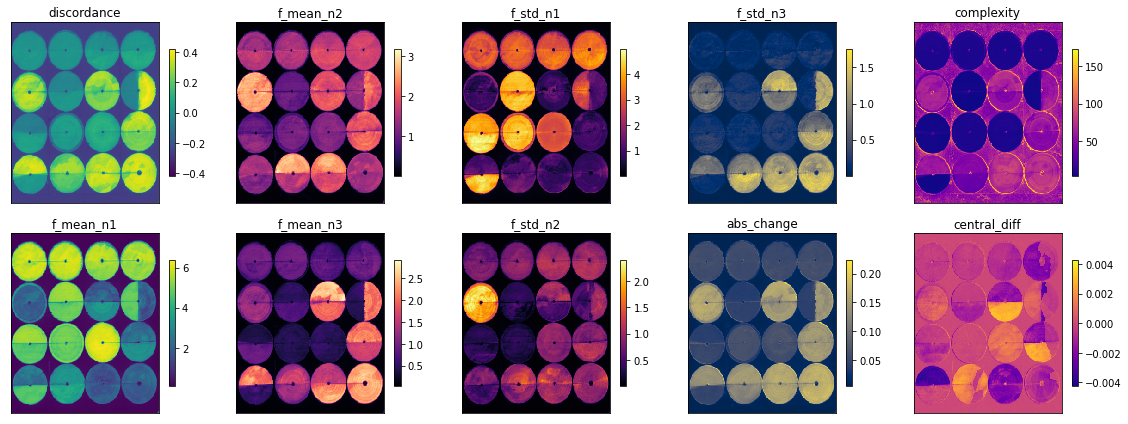

In [36]:
fig, axes = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(16,6),
                       sharex=True,
                       sharey=True)

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')
    
# set colorbar size
cbar_size = 0.7
stats = ['discordance','f_mean_n1','f_mean_n2', 'f_mean_n3', 'f_std_n1',
         'f_std_n2', 'f_std_n3','abs_change','complexity','central_diff']
# set aspect ratios
for ax,stat_1,stat_2,stat_3,stat_4,stat_5 in zip(axes,stats[0:2], stats[2:4],stats[4:6],stats[6:8],stats[8:10]):
    x[stat_1].plot(ax=ax[0],cmap='viridis',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[0].set_title(stat_1)
    ax[0].xaxis.set_visible(False)
    ax[0].yaxis.set_visible(False)
    
    x[stat_2].plot(ax=ax[1],cmap='magma',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[1].set_title(stat_2)
    ax[1].xaxis.set_visible(False)
    ax[1].yaxis.set_visible(False)
    
    x[stat_3].plot(ax=ax[2],cmap='inferno',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[2].set_title(stat_3)
    ax[2].xaxis.set_visible(False)
    ax[2].yaxis.set_visible(False)
    
    x[stat_4].plot(ax=ax[3],cmap='cividis',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[3].set_title(stat_4)
    ax[3].xaxis.set_visible(False)
    ax[3].yaxis.set_visible(False)
    
    x[stat_5].plot(ax=ax[4],cmap='plasma',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[4].set_title(stat_5)
    ax[4].xaxis.set_visible(False)
    ax[4].yaxis.set_visible(False)

plt.tight_layout();


In [37]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': ('2018-07', '2018-12'),
    'measurements': ['red', 'nir'],
    'resolution': (-10,10),
    'output_crs': 'epsg:6933'
}


# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              **query
              )

ds = calculate_indices(ds, index=veg_proxy, collection='s2')

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 34 time steps


In [38]:
%%time
phen = xr_phenology(ds.NDVI,
                    method_sos='median',
                    method_eos='median',
                    complete='fast_complete',
                    smoothing='rolling_mean')
phen

Completing using fast_complete...
   Smoothing with rolling mean...
      Phenology...
         POS
         EOS
         Trough
         vSOS
         vPOS
         vEOS
         LOS
         AOS
         ROG
         ROS
CPU times: user 430 ms, sys: 4.22 ms, total: 435 ms
Wall time: 433 ms


<xarray.Dataset>
Dimensions:      (x: 320, y: 390)
Coordinates:
  * x            (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
  * y            (y) float64 2.837e+06 2.837e+06 ... 2.833e+06 2.833e+06
    spatial_ref  int32 0
Data variables:
    SOS          (y, x) int16 182 182 182 182 182 182 ... 262 232 182 247 182
    POS          (y, x) int16 187 182 182 182 182 182 ... 277 277 182 277 182
    EOS          (y, x) int16 232 257 247 247 302 227 ... 297 332 252 287 227
    Trough       (y, x) float32 0.05736671 0.055107407 ... 0.0553912 0.05334112
    vSOS         (y, x) float32 0.08148703 0.0 0.0 0.0 ... 0.0 0.06391786 0.0
    vPOS         (y, x) float32 0.081880406 0.083521426 ... 0.08525754
    vEOS         (y, x) float32 0.07168396 0.07177585 ... 0.06334476 0.065585285
    LOS          (y, x) int16 50 75 65 65 120 45 115 ... 145 60 35 100 70 40 45
    AOS          (y, x) float32 0.024513695 0.028414018 ... 0.031916417
    ROG          (y, x) float32 7.867515e-05 inf inf ... inf 0.00048860884 inf
    ROS          (y, x) float32 -0.00022658773 -0.00015660762 ... -0.00043716116
Attributes:
    grid_mapping:  spatial_ref

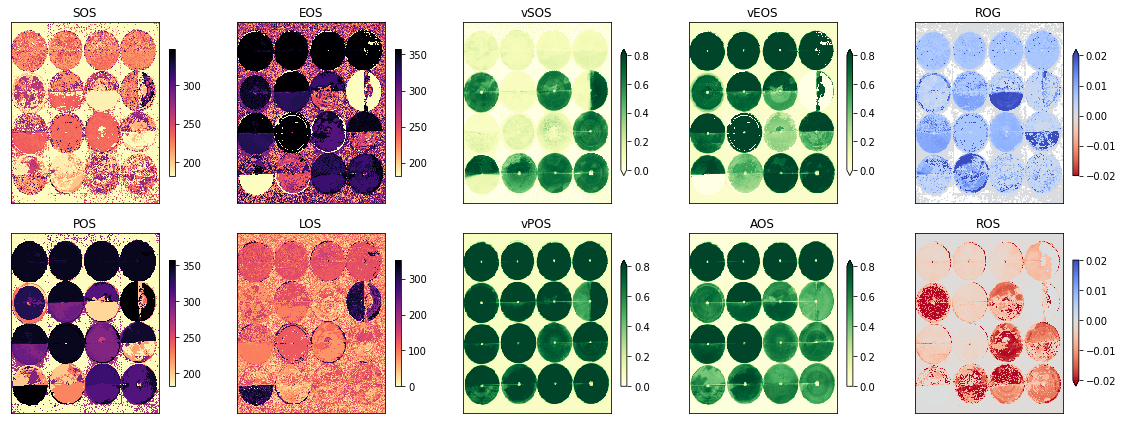

In [39]:
fig, axes = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(16,6),
                       sharex=True,
                       sharey=True)

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')
    
# set colorbar size
cbar_size = 0.7
stats=["SOS",
        "POS",
        "EOS",
        "LOS",
        "vSOS",
        "vPOS",
        "vEOS",
        "AOS",
        "ROG",
        "ROS",
    ]
# set aspect ratios
for ax,stat_1,stat_2,stat_3,stat_4,stat_5 in zip(axes,stats[0:2], stats[2:4],stats[4:6],stats[6:8],stats[8:10]):
    phen[stat_1].plot(ax=ax[0],cmap='magma_r',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[0].set_title(stat_1)
    ax[0].xaxis.set_visible(False)
    ax[0].yaxis.set_visible(False)
    
    phen[stat_2].plot(ax=ax[1],cmap='magma_r',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[1].set_title(stat_2)
    ax[1].xaxis.set_visible(False)
    ax[1].yaxis.set_visible(False)
    
    phen[stat_3].plot(ax=ax[2],cmap='YlGn',vmax=0.8,
               vmin=0,cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[2].set_title(stat_3)
    ax[2].xaxis.set_visible(False)
    ax[2].yaxis.set_visible(False)
    
    phen[stat_4].plot(ax=ax[3],cmap='YlGn',vmax=0.8,
               vmin=0,cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[3].set_title(stat_4)
    ax[3].xaxis.set_visible(False)
    ax[3].yaxis.set_visible(False)
    
    phen[stat_5].plot(ax=ax[4],cmap='coolwarm_r',vmin=-0.02,
              vmax=0.02,cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[4].set_title(stat_5)
    ax[4].xaxis.set_visible(False)
    ax[4].yaxis.set_visible(False)

plt.tight_layout();


In [18]:
# ds.NDVI.time.dt.dayofyear.max()

In [19]:
los = phen.EOS - Psos
z = ds.NDVI.time.dt.dayofyear.max() + (phen.EOS.where(phen.LOS < 0) - phen.SOS.where(phen.LOS < 0))

NameError: name 'Psos' is not defined

In [ ]:
z.plot()

In [ ]:
%%time
phen1 = xr_phenology(ds1.NDVI,
                    method_sos='median',
                    method_eos='median',
                    complete='fast_complete',
                    smoothing='wiener')
phen1

In [ ]:
z  = phen - phen1

In [ ]:
phen.SOS.plot()

In [ ]:
phen1.SOS.plot()

In [ ]:
z.SOS.plot()

In [ ]:
i_complete=fast_completion(i.NDVI)

In [ ]:
i_complete.mean(['x', 'y']).plot()

In [ ]:
x=smooth(i_complete)

In [ ]:
x.mean(['x', 'y']).plot()

In [ ]:
z = I_mapblocks - i_complete

In [ ]:
template=i.NDVI.drop('spatial_ref')

I_mapblocks = i.NDVI.map_blocks(
    fast_completion,
    template=template)

# I_mapblocks

In [ ]:
template=I_mapblocks

I_mapblocks_smooth = I_mapblocks.map_blocks(
    smooth,
    template=template).compute()

In [ ]:
I_mapblocks_smooth.mean(['x', 'y']).plot()

In [ ]:
j = I_mapblocks_smooth - x

In [ ]:
j.mean(['x', 'y']).plot()

In [ ]:
# def poly_fit(time, data, degree):
    
#     pfit = np.polyfit(time, data, degree) 
    
#     return np.transpose(np.polyval(pfit,time))

# def poly_fit_smooth(time, data, degree, n_pts):
#         """
#         """
    
#         time_smooth_inds = np.linspace(0, len(time), n_pts)
#         time_smooth = np.interp(time_smooth_inds, np.arange(len(time)), time)

#         data_smooth = np.array([np.array([coef * (x_val ** current_degree) for
#                                 coef, current_degree in zip(np.polyfit(time, data, degree),
#                                 range(degree, -1, -1))]).sum() for x_val in time_smooth])

#         return data_smooth

# def xr_polyfit(doy,
#                da,
#                degree,
#                interp_multiplier=1):    
    
#     # Fit polynomial curve to observed data points
#     if interp_multiplier==1:
#         print('Fitting polynomial curve to existing observations')
#         pfit = xr.apply_ufunc(
#             poly_fit,
#             doy,
#             da, 
#             kwargs={'degree':degree},
#             input_core_dims=[["time"], ["time"]], 
#             output_core_dims=[['time']],
#             vectorize=True,  
#             dask="parallelized",
#             output_dtypes=[da.dtype],
#         )
    
#     if interp_multiplier > 1:
#         print("Fitting polynomial curve to "+str(len(doy)*interp_multiplier)+
#                                                       " interpolated points")
#         pfit = xr.apply_ufunc(
#             poly_fit_smooth,  # The function
#             doy,# time
#             da,#.chunk({'time': -1}), #the data
#             kwargs={'degree':degree, 'n_pts':len(doy)*interp_multiplier},
#             input_core_dims=[["time"], ["time"]], 
#             output_core_dims=[['new_time']], 
#             output_sizes = ({'new_time':len(doy)*interp_multiplier}),
#             exclude_dims=set(("time",)),
#             vectorize=True, 
#             dask="parallelized",
#             output_dtypes=[da.dtype],
#         ).rename({'new_time':'time'})
    
#         # Map 'dayofyear' onto interpolated time dim
#         time_smooth_inds = np.linspace(0, len(doy), len(doy)*interp_multiplier)
#         new_datetimes = np.interp(time_smooth_inds, np.arange(len(doy)), doy)
#         pfit = pfit.assign_coords({'time':new_datetimes})
    
#     return pfit

# # da=xr_polyfit(dayofyear=dayofyear, 
# #               da=da,
# #               degree=degree,
# #               interp_multiplier=interp_multiplier)

In [ ]:
# #set up figure
# fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(18,25), sharex=True, sharey=True)

# #start of season
# temp_stats.discordance.plot(ax=ax[0,0])
# ax[0,0].set_title('discordance')
# temp_stats.f_std.plot(ax=ax[0,1])
# ax[0,1].set_title('f_std')

# #peak of season
# temp_stats.f_mean.plot(ax=ax[1,0])
# ax[1,0].set_title('f_mean')
# phen.f_median.plot(ax=ax[1,1])
# ax[1,1].set_title('f_median')

# #end of season
# temp_stats.mean_change.plot(ax=ax[2,0])
# ax[2,0].set_title('mean_change')
# phen.med_change.plot(ax=ax[2,1])
# ax[2,1].set_title('med_change')

# #Length of Season
# temp_stats.abs_change.plot(ax=ax[3,0])
# ax[3,0].set_title('abs_change');

# #Amplitude
# temp_stats.complexity.plot(ax=ax[3,1])
# ax[3,1].set_title('complexity')

# #rate of growth
# temp_stats.central_diff.plot(ax=ax[4,0])
# ax[4,0].set_title('central_diff')

# #rate of Sensescence
# temp_stats.num_peaks.plot(ax=ax[4,1])
# ax[4,1].set_title('num_peaks');

# plt.tight_layout();